# Predicting Listing Gains in the Indian IPO Market

In this project we're predicting listing IPO market in India using deep learning in TensorFlow. The dataset contans information on past IPOs in the Indian market from [moneycontrol](https://www.moneycontrol.com/ipo/listed-ipos/?classic=true) 

In [2]:
# Importing required libraries:
# we'll recall it later to pinpoint where it's used.

# General modules:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Modules for deep learning purposes:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

2024-02-18 15:11:09.855832: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('Indian_IPO_Market_Data.csv')
print(df.shape)

(319, 9)


In [4]:
df.head()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


In [5]:
df.tail()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
314,26/08/22,Syrma SGS,840.13,42.42,7.13,2.84,15.59,220,42.30
315,06/09/22,Dreamfolks Serv,562.10,27.48,14.18,24.19,23.25,326,41.92
316,15/09/22,TMB,792.00,0.51,1.77,3.44,1.39,525,-3.15
317,26/09/22,Harsha Engineer,755.00,113.82,40.36,12.44,47.19,330,47.24
318,17/10/22,Electronics Mar,500.00,58.81,15.39,8.27,24.23,59,43.14


In [6]:
# Descriptive Statistics of Target
df['Listing_Gains_Percent'].describe()

count    319.000000
mean       4.742696
std       47.650946
min      -97.150000
25%      -11.555000
50%        1.810000
75%       25.310000
max      270.400000
Name: Listing_Gains_Percent, dtype: float64

## Exploring the Data

We'll be making a deep learning classification if a company will have a listing gain from the numerical values within the dataset. However, our target variable, `Listing_Gains_Percent`, has continuous values. We'll be making a new categorical column that has `1` for positive values and `0` for negative values.

In [7]:
df['Listing_Gains_Profit'] = np.where(
    df['Listing_Gains_Percent'] > 0, 1, 0)

df['Listing_Gains_Profit'].value_counts(normalize=True) * 100

1    54.545455
0    45.454545
Name: Listing_Gains_Profit, dtype: float64

In [8]:
# Any missing values?
df.isna().sum()

Date                     0
IPOName                  0
Issue_Size               0
Subscription_QIB         0
Subscription_HNI         0
Subscription_RII         0
Subscription_Total       0
Issue_Price              0
Listing_Gains_Percent    0
Listing_Gains_Profit     0
dtype: int64

We've defined our categorical target and by counting the values, we can see that an average IPO tends to list a profit with a percentage of 54,54%. 

We now can look for summary statistics to tell which columns we use for modeling.

In [9]:
# All descriptive statistics:
df.describe(include='all')

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent,Listing_Gains_Profit
count,319,319,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
unique,287,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,16/08/21,Infinite Comp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1192.859969,25.684138,70.091379,8.561599,27.447147,375.128527,4.742696,0.545455
std,NaN,NaN,2384.643786,40.716782,142.454416,14.508670,48.772203,353.897614,47.650946,0.498712
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-97.150000,0.000000
25%,NaN,NaN,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,-11.555000,0.000000
50%,NaN,NaN,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.810000,1.000000
75%,NaN,NaN,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,25.310000,1.000000


* We apparently don't need ordinal values for this, therefore we can drop `Date` and `IPOName`
* We've assigned our categorical target either, so we can delete `Listing_Gains_Percent`.

In [10]:
df = df.drop(['Date ', 'IPOName', 'Listing_Gains_Percent'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Issue_Size            319 non-null    float64
 1   Subscription_QIB      319 non-null    float64
 2   Subscription_HNI      319 non-null    float64
 3   Subscription_RII      319 non-null    float64
 4   Subscription_Total    319 non-null    float64
 5   Issue_Price           319 non-null    int64  
 6   Listing_Gains_Profit  319 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 17.6 KB


## Data Visualization

We can get more insights by making pictures of data visualization to see for distribution and correlation in columns.

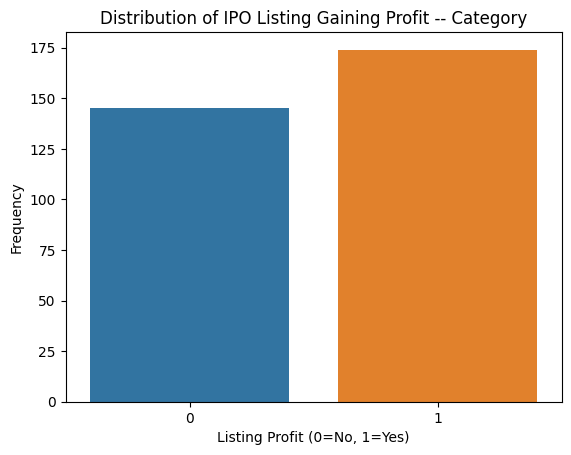

In [11]:
sns.countplot(data=df, x='Listing_Gains_Profit')
plt.title('Distribution of IPO Listing Gaining Profit -- Category')
plt.xlabel('Listing Profit (0=No, 1=Yes)')
plt.ylabel('Frequency')
plt.show()

To check outliers, instead of looking on each histogram, we can look for its `skew()` or the tail in distribution first, and then we'll go from there. Left-skewed will have negative values and vice-versa. The higher the value shows how more skewed the distribution is.

In [12]:
df.skew()

Issue_Size              4.853402
Subscription_QIB        2.143705
Subscription_HNI        3.078445
Subscription_RII        3.708274
Subscription_Total      2.911907
Issue_Price             1.696881
Listing_Gains_Profit   -0.183438
dtype: float64

Seems like each column does have outliers. We'll check it in parallel with the correlations.

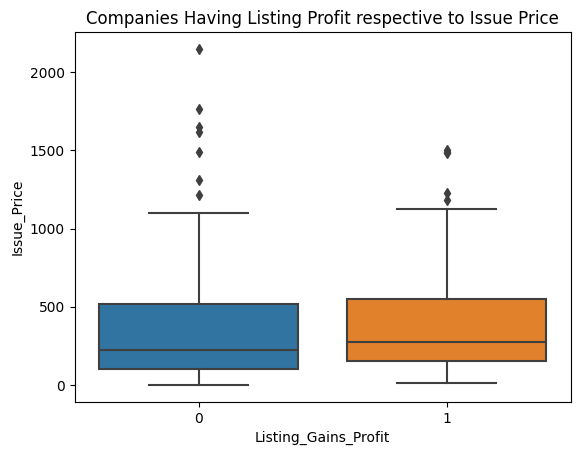

In [13]:
sns.boxplot(data=df, x='Listing_Gains_Profit', y='Issue_Price')
plt.title('Companies Having Listing Profit respective to Issue Price')
plt.show()

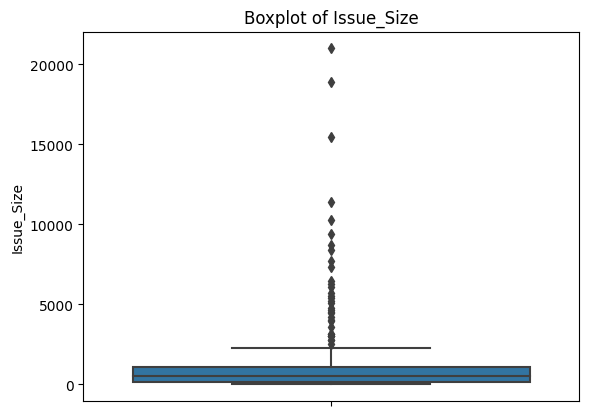

In [14]:
sns.boxplot(data=df, y='Issue_Size')
plt.title('Boxplot of Issue_Size')
plt.show()

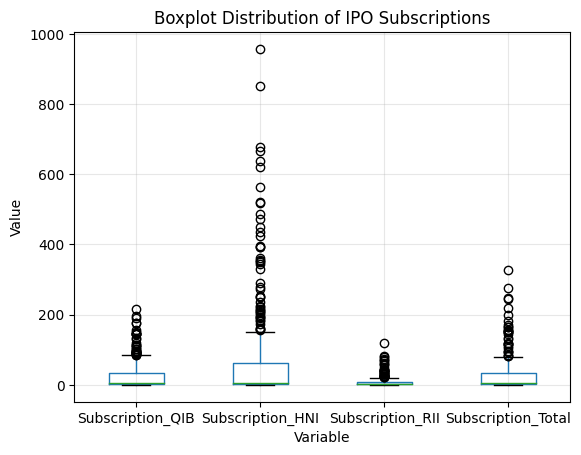

In [15]:
subs = ['Subscription_QIB', 'Subscription_HNI',
        'Subscription_RII', 'Subscription_Total']

# Subscription_XXX Terms:
## QIB  : Qualified Institutional Buyer
## HNI  : High-Networth Individual
## RII  : Retail Individual Investors
## Total: Overall

df[subs].boxplot()
plt.xlabel('Variable')
plt.ylabel('Value')
plt.title('Boxplot Distribution of IPO Subscriptions')

plt.grid(alpha=0.3)
plt.show()

Here are some findings:

* There are a lot of outliers across the numerical values.

* Apparently, there are more outliers in `Issue_Price` on companies that do not gain listing profit.

* IPO subscriptions are dominated by High-Networth Individual (`Subscription_HNI`) on the collective boxplot.

## Outlier Treatment

We can treat the outliers by using interquartile range to see values that is out of upper and lower bounds. For convenience, we can define the columns of `predictors` and `target_variables` early for clipping iterations. 

Notice that we don't include `Issue_Price` in this step. It's a fixed number attached to each company, so we'll leave it as is.

In [16]:
target_variable = ['Listing_Gains_Profit']
issue_price = ['Issue_Price']

predictors = list(set(list(df.columns)) - set(target_variable))
clipped_cols = list(set(predictors) - set(issue_price))

clipped_cols

['Subscription_HNI',
 'Issue_Size',
 'Subscription_QIB',
 'Subscription_Total',
 'Subscription_RII']

In [17]:
for col in clipped_cols:
    
    # Define the quartiles
    q1    = df[col].quantile(q=0.25)
    q3    = df[col].quantile(q=0.75)
    iqr   = q3 - q1
    lower = (q1 - 1.5 * iqr)
    upper = (q3 + 1.5 * iqr)
    
    # Clip the values only within the bounds
    df[col] = df[col].clip(lower, upper)
    
df.describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,763.561238,21.521183,40.356426,6.060940,20.456646,375.128527,0.545455
std,769.689122,29.104549,57.427921,6.176882,27.217740,353.897614,0.498712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,0.000000
50%,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.000000
75%,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,1.000000
max,2496.492500,84.862500,153.355000,19.600000,81.020000,2150.000000,1.000000


With extreme range of values in each column, we need to normalize all the `predictors` for uniform distribution of `0-1` across the board. 

In [18]:
df[predictors] = df[predictors] / df[predictors].max()
df.describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,0.305854,0.253601,0.263157,0.309232,0.252489,0.174478,0.545455
std,0.308308,0.342961,0.374477,0.315147,0.335939,0.164604,0.498712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.067697,0.013551,0.008184,0.065051,0.020304,0.055349,0.000000
50%,0.198779,0.058212,0.033061,0.174490,0.060849,0.116279,1.000000
75%,0.440618,0.408131,0.404910,0.439031,0.412182,0.249302,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Creating the Holdout Validation Approach

Now let's divide the dataset into training and test set. We'll be using a ratio of `70:30` seeing there are only hundreds of entries. A larger ratio would result in lesser entries in test set.

In [19]:
X = df[predictors].values
y = df[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100)

## Define the Deep Learning Classification Model

We can proceed to defining the model in deep learning. We'll make a neural network consisting of an `input_layer`, four `hidden_layer`s, and an `output_layer` in the end. 

We'll be using an activation function of *Rectified LInear Unit* (ELU) for the input and hidden layers since we've normalized the values to be a positive `0-1`. Lastly we'll use *Sigmoid* function on the output layer to make a neat result, back to `0-1`.

In [20]:
tf.random.set_seed(100)

# DEFINE THE MODEL
model = tf.keras.Sequential()
# Input layer:
model.add(tf.keras.layers.Dense(32,
    input_shape=(X_train.shape[1],), activation='relu'))
# Hidden layers:
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense( 8, activation='relu'))
model.add(tf.keras.layers.Dense( 4, activation='relu'))
# Output layer:
model.add(tf.keras.layers.Dense( 1, activation='sigmoid'))

2024-02-18 15:11:12.309339: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-02-18 15:11:12.309574: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.199.2 does not match DSO version 470.161.3 -- cannot find working devices in this configuration


## Compile and Train the Model

We'll be using `Adam` optimizer with loss of `BinaryCrossentropy()` and metrics of `accuracy` to compile the model.

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
             )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train, y_train, epochs=250, verbose=0)

## Model Evaluation

Now we'll determine how well our model's performing by evaluating the model. Consider these questions in mind to fine-tune our model for b:

* What is the overall training accuracy on the train and test datasets?

* Is there accuracy consistent across both the train and test datasets, or is there a chance your model is overfitting?



In [30]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))

7/7 [==============================] - 0s 1ms/step - loss: 0.2279 - accuracy: 0.8969
[0.22786875069141388, 0.8968609571456909]
3/3 [==============================] - 0s 2ms/step - loss: 1.6028 - accuracy: 0.7396
[1.6027570962905884, 0.7395833134651184]


We can see that the accuracy for both training and test set are `74.44%` and `68.75%`. There is inconsistency between both types of set, therefore we need to adjust the model to, not only match both results better, but also increase the accuracy.

We can approach optimizing the model by:

* **Hyperparameter Optimization:** Tuning values of argument in a function such as learning rate, number of layers, etc.

* **Optimizers and Loss Functions:** Different options for both documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) and [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses)

* **Features:** Construct new fatures that may be strongly correlated with the target variable.

* **Performance Metrics:** Trying other performance metrics to see if it helps guide the model towards better results.

* **Domain Specific Knowledge:** Adjust model to a knowledge to enhance performance and accuracy.